<a href="https://colab.research.google.com/github/OmkarKotwalProject/McDonalds_Work/blob/main/McDonalds_Work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
import sklearn.metrics as sm
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
!pip install pyspellchecker
!pip install Counter

nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

     |████████████████████████████████| 2.7 MB 21.4 MB/s 
  Created wheel for Counter: filename=Counter-1.0.0-py3-none-any.whl size=5411 sha256=d4688ae0066ab6e30cdb897884ff582c48fd7cec621de64913eec46b566cf3b2
  Stored in directory: /root/.cache/pip/wheels/f9/15/75/7a0462a00beb08e391f5da370ca409b56781d2501dba083fa3
Successfully built Counter
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
pd.set_option("display.max_rows",500)
pd.set_option("display.max_columns",None)
pd.set_option("display.max_colwidth",None)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files
import io


uploaded = files.upload()
df= pd.read_excel(io.BytesIO(uploaded['All_Reviews_MD.xlsx']))

Saving All_Reviews_MD.xlsx to All_Reviews_MD.xlsx


In [ ]:
#Keeping the original as it is.
df_review=df 

THIS IS A BACKUP LOAD OF ORIGINAL DATAFRAME, ONLY USE IF MESSED UP

In [ ]:
# #FOR EMPTYING THE DATAFRAME
#df_review.drop(columns=['Review','Sentiment'],inplace=True)

In [ ]:
# #FOR RELOADING WITH ORIGINAL RAW DATA
# df= pd.read_excel(io.BytesIO(uploaded['All_Reviews_PH.xlsx']))
# df_review=df

BACKUP CODE END

In [ ]:
print(df_review.head())
print(df_review.shape)

                                                                                                     Review  \
0  Sitting arrangement is really bad, kept on moving here and there not happy, they should take care for it   
1                                                               Spacious.. Friendly, kind and helpful staff   
2                                  Always very crowded, non co-operative staff, will never advice to visit.   
3                                                                                            Amazing places   
4                                               Not service are good.always take time on single order also.   

   Sentiment  
0          0  
1          1  
2          0  
3          1  
4          0  
(3016, 2)


HOW MANY POSITIVE REVIEWS, HOW MANY NEGATIVE REVIEWS

In [ ]:
print(df_review[df_review['Sentiment']==1].count())
print(df_review[df_review['Sentiment']==0].count())

Review       2212
Sentiment    2212
dtype: int64
Review       804
Sentiment    804
dtype: int64


#PRE-PROCESSING!

1. ^[\w\s]=remove all except alphanumeric and whitespaces tabs and spaces [\d] remove digits

In [ ]:
#REMOVING NUMBERS 
df_review['Review']=df_review['Review'].replace('\d+','',regex=True)

2. WHAT AM I TRYING TO DO HERE:- Removing more than 2 consecutive occurrences of a character, if its a special char, replace with space

so @@@@@@ => @@ and then '__'. This will happen with words too, hellllloo => helloo


In [ ]:
#WHAT AM I TRYING TO DO HERE:-  Removing more than 2 consecutive occurrences of a character, if its a special char, replace with space
# so @@@@@@ => @@ and then '__'. This will happen with words too, hellllloo => helloo
#1. REPLACE SPECIAL CHARACTERS BY ' ' AND then using regex, remove consecutive duplicates of ' ' i.e '         '  (big spaces between words)
df_review['Review']=df_review['Review'].replace('\n', ' ',regex=True)
df_review['Review']=df_review['Review'].replace(('[^!|^.|^,|^;|^-|^@|^\w\s]'),"", regex = True)
for i in range(len(df_review)):
  sentence=df_review['Review'][i]
  sentence=sentence.replace('.', ' ')
  sentence=sentence.replace(',', ' ')
  sentence=sentence.replace('!', ' ')
  sentence=sentence.replace('.', ' ')
  sentence=sentence.replace(';', ' ')
  sentence=sentence.replace('-', ' ')
  sentence=sentence.replace('@', ' ')
  sentence=sentence.replace(')', ' ')
  sentence=sentence.replace('(', ' ')
  sentence=sentence.replace('{', ' ')
  sentence=sentence.replace('}', ' ')

  sentence=re.sub(r'(.)\1+', r'\1\1',sentence)   # yummmyyy => yummyy,  '     '=>'  '  #This line will remove char which occures more than 2 times consecutively.
  df_review['Review'][i]=sentence

#df_review['Review']=df_review['Review'].replace('[^\w\s]', '',regex=True)
print(df_review.head(10))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


                                                                                                                              Review  \
0                           Sitting arrangement is really bad  kept on moving here and there not happy  they should take care for it   
1                                                                                         Spacious  Friendly  kind and helpful staff   
2                                                            Always very crowded  non cooperative staff  will never advice to visit    
3                                                                                                                     Amazing places   
4                                                                        Not service are good always take time on single order also    
5                                                                             Great place  quick service  food was tasty like alwats   
6                                               

3. REMOVING CHARACTERS WHICH ONLY OCCUR ONCE! ALSO REPLACING TWO CONSECUTIVE SPACES BY ONE

In [ ]:
cnter=0
while(cnter<2):
  for i in range(len(df_review)):
    new_sentence=" "
    sentence=df_review['Review'][i]    #get the row i.e. sentence
    #print("before removing:",df_review['Review'][i])
    words=sentence.split()  #makes a list of the words in the sentence
    for word in words:      #check every words length and if it is less than 2, remove it
      if len(word)<2:
        #print(word)
        words.remove(word)
    new_sentence=new_sentence.join(words) #Create a new sentence by joining all the words in the list with " " as a separator
    df_review['Review'][i]=new_sentence   #replace current row i.e. sentence by the new sentence
    #print("after removing:",df_review['Review'][i])
  cnter=cnter+1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [ ]:
#printing word if length is less than 2
for i in range(len(df_review)):
  sentence=df_review['Review'][i]
  words=sentence.split()  #makes a list of the words in the sentence
  for word in words:      #check every words length and if it is less than 2, print it
    if len(word)<2:
      print(word)

In [ ]:
print(df_review.head(5))

                                                                                                   Review  \
0  Sitting arrangement is really bad kept on moving here and there not happy they should take care for it   
1                                                                Spacious Friendly kind and helpful staff   
2                                    Always very crowded non cooperative staff will never advice to visit   
3                                                                                          Amazing places   
4                                              Not service are good always take time on single order also   

   Sentiment  
0          0  
1          1  
2          0  
3          1  
4          0  


4. Print the rows with Missing NAN values

In [ ]:
print(df_review[df_review.isna().any(axis=1)])

Empty DataFrame
Columns: [Review, Sentiment]
Index: []


Converting datatype of a column, here tried to convert float type of Sentiment to int

In [ ]:
#print(df_review['Sentiment'].astype(int))

4. FINDING MISSPELLED WORDS AND CORRECTING THEM!

Algorithm used for correcting words:

    Create a list of misspelled words found in the dataset.
    Create a list of correctly spelled words found in the dataset.
    Use similar() function of 'SequenceMatcher' for finding similarity between words from both lists. If it is greater than 0.8, create a dictionary (dict['misspelled word'=correctly spelled word.
    Now traverse the dataset, while checking a row, extract its misspelled words, check if misspelled word is in the dictionary, if it is then replace it with correctly spelled word.



In [ ]:
#This creates a list of sets of misspelled words found in each row.
from spellchecker import SpellChecker
spell=SpellChecker()
mis_list=[]
for i in range(len(df_review)):
  sentence=df_review['Review'][i].split()
  mis_sent=spell.unknown(sentence)
  mis_list.append(mis_sent)
  if set() in mis_list:
    mis_list.remove(set())
print("first 50 row's Misspelled words but they are in [{misspelled words list from row 1},{misspelled words list from row 2}]: ",mis_list[0:50])

first 50 row's Misspelled words but they are in [{misspelled words list from row 1},{misspelled words list from row 2}]:  [{'alwats'}, {'covid'}, {'bt', 'choclate'}, {'dnt', 'mcd'}, {'donalds', 'mc'}, {'tikki'}, {'estable'}, {'dilevery', 'contactless'}, {'coverd'}, {'mcpuff'}, {'tikki', 'mc'}, {'tikki', 'mcaloo', 'chesse'}, {'tikki', 'tomotoes'}, {'tikki', 'chatapata'}, {'mcdonaldspricepiri', 'mcdits', 'sider', 'frieslocation', 'mixfries', '__for', 'theflavourjunction', 'piri'}, {'sanitization'}, {'kfc'}, {'mutar', 'kabab', 'mcpuff'}, {'donalds', 'mc'}, {'hygienefoodrecommendation'}, {'foodwarden', 'mc', 'tejasawant', 'donalds'}, {'varietys', 'quntity'}, {'mc'}, {'cripsy', 'mc', 'mcfries'}, {'obvio'}, {'contactless'}, {'tikki', 'tamatos', 'tikkis', 'mcaloo'}, {'mc'}, {'tht'}, {'mcveggie', 'borivali', 'mc', 'mcd'}, {'mc'}, {'covid'}, {'lovved', 'ehuch', 'ambiemce', 'differemt', 'waitong'}, {'maharajamac'}, {'mc'}, {'mc'}, {'schezwan', 'mc'}, {'tikki', 'minimised', 'st'}, {'chatpata', 'm

In [ ]:
#Creating a list of misspelled words. (Basically extracting each set element from the mis_list and putting it into mis_mis_list)

from collections import Counter
mis_mis_list=[]
for i in mis_list:
  for j in i:
    mis_mis_list.append(j.lower())   #just making the words lower before appending to mis_mis_list


#cnt=0
#for i in mis_mis_list:        #removing 'rs', 'mr', 'ms' from the list as they aren't misspelled words in a way.
  # if i=='rs':
  #   #cnt=cnt+1
  #   mis_mis_list.remove(i)
  # if i=='mr':
  #   mis_mis_list.remove(i)
  # if i=='ms':
  #   mis_mis_list.remove(i)    
print("first 50 Misspelled words:",mis_mis_list[0:50]) #LIST OF MISSPELLED WORDS   

#Creating this names_list, as names are needed to be removed from the misspelled words list. (It will be removed in the next cell)
names_list=['mc','donalds','mcdonalds','mcd','mccafe','tikki','zomato','mcspicy','chinchwad','mcveggie','sv','kandivali','mcflurry',
            'sakinaka','mcpuff','pm','pcmc','chatpata','dahisar','nonveg','shraddha','covid','contactless','pimpri','kfc','andheri'
            'mcdelivery','mcswirl','akhilesh','paytm','mcegg','mcmaharaja','jain','meetups','periperi','mcaloo']
print("Total misspelled words: ",len(mis_mis_list)) #Note: this list is not a 'unique mispelled words' list, it has repeated occurences of them.


#Finding common words and their occurrences in the mis_mis_list #Just a trial code for common words finder.
cnt=Counter(mis_mis_list)
cmmn=cnt.most_common(100)   
print(cmmn)

first 50 Misspelled words: ['alwats', 'covid', 'bt', 'choclate', 'dnt', 'mcd', 'donalds', 'mc', 'tikki', 'estable', 'dilevery', 'contactless', 'coverd', 'mcpuff', 'tikki', 'mc', 'tikki', 'mcaloo', 'chesse', 'tikki', 'tomotoes', 'tikki', 'chatapata', 'mcdonaldspricepiri', 'mcdits', 'sider', 'frieslocation', 'mixfries', '__for', 'theflavourjunction', 'piri', 'sanitization', 'kfc', 'mutar', 'kabab', 'mcpuff', 'donalds', 'mc', 'hygienefoodrecommendation', 'foodwarden', 'mc', 'tejasawant', 'donalds', 'varietys', 'quntity', 'mc', 'cripsy', 'mc', 'mcfries', 'obvio']
Total misspelled words:  2116
[('mc', 257), ('mcd', 192), ('tikki', 110), ('borivali', 79), ('donalds', 72), ('mccafe', 56), ('zomato', 31), ('mcspicy', 28), ('rs', 27), ('mcaloo', 25), ('piri', 25), ('chinchwad', 23), ('macd', 22), ('mcveggie', 20), ('sv', 16), ('kandivali', 16), ('mcflurry', 16), ('kora', 15), ('mcds', 15), ('sakinaka', 13), ('mcpuff', 12), ('nd', 12), ('pm', 11), ('mcchicken', 11), ('pcmc', 10), ('chatpata', 9)

In [ ]:
#REMOVING NAMES FROM THE LIST of misspelled words
for name in names_list:
  for j in range(len(mis_mis_list)):
    if name in mis_mis_list:
      mis_mis_list.remove(name)
print("Final Misspelled words list after removing names: (Showing only first 50) ",mis_mis_list[0:50]) #This is the list of misseplled words!



#Trial code for common words finder, again.
cnt=Counter(mis_mis_list)
cmmn=cnt.most_common(100)   #Finding common words and their occurrences in the mis_mis_list     
print(cmmn)    

Final Misspelled words list after removing names: (Showing only first 50)  ['alwats', 'bt', 'choclate', 'dnt', 'estable', 'dilevery', 'coverd', 'chesse', 'tomotoes', 'chatapata', 'mcdonaldspricepiri', 'mcdits', 'sider', 'frieslocation', 'mixfries', '__for', 'theflavourjunction', 'piri', 'sanitization', 'mutar', 'kabab', 'hygienefoodrecommendation', 'foodwarden', 'tejasawant', 'varietys', 'quntity', 'cripsy', 'mcfries', 'obvio', 'tamatos', 'tikkis', 'tht', 'borivali', 'lovved', 'ehuch', 'ambiemce', 'differemt', 'waitong', 'maharajamac', 'schezwan', 'minimised', 'st', 'deffers', 'rs', 'piri', 'tikkas', 'favs', 'ppt', 'rs', 'renovationcopying']
[('borivali', 79), ('rs', 27), ('piri', 25), ('macd', 22), ('kora', 15), ('mcds', 15), ('nd', 12), ('mcchicken', 11), ('kabab', 8), ('ds', 8), ('yumm', 8), ('bt', 7), ('ppl', 6), ('st', 5), ('maxican', 5), ('frnds', 5), ('café', 5), ('bday', 5), ('hrs', 5), ('aaloo', 5), ('pls', 5), ('choclate', 4), ('andheri', 4), ('mcdelivery', 4), ('nt', 4), ('r

In [ ]:
#Finding a list of correctly spelled words!
#first, just creating a list of words found in the dataset
correct_word_list=[]
for i in range(len(df_review)):
  sentence=df_review['Review'][i]
  words=sentence.split()
  for word in words:
    correct_word_list.append(word.lower())
print(correct_word_list[0:50])


['sitting', 'arrangement', 'is', 'really', 'bad', 'kept', 'on', 'moving', 'here', 'and', 'there', 'not', 'happy', 'they', 'should', 'take', 'care', 'for', 'it', 'spacious', 'friendly', 'kind', 'and', 'helpful', 'staff', 'always', 'very', 'crowded', 'non', 'cooperative', 'staff', 'will', 'never', 'advice', 'to', 'visit', 'amazing', 'places', 'not', 'service', 'are', 'good', 'always', 'take', 'time', 'on', 'single', 'order', 'also', 'great']


In [ ]:
#We have to make both lists mis_mis_list and correct_words_list contain unique words, not repeated words or 'remove' won't work!
print("total of all words of misspelled word list:",len(mis_mis_list))
print("total of all words of correct word list+misspelled word list:",len(correct_word_list))
mis_mis_list=list(set(mis_mis_list))
correct_word_list=list(set(correct_word_list))
print("total of unique words of misspelled word list:",len(mis_mis_list))
print("total of unique words of correct word list+missplled word list:",len(correct_word_list))
print("total of unique words of names list:",len(names_list))

total of all words of misspelled word list: 1127
total of all words of correct word list+misspelled word list: 70299
total of unique words of misspelled word list: 730
total of unique words of correct word list+missplled word list: 4784
total of unique words of names list: 35


In [ ]:
print("correct word list length before removing misspelled words and names:",len(correct_word_list))
names_list=['mc','donalds','mcdonalds','mcd','mccafe','tikki','zomato','mcspicy','chinchwad','mcveggie','sv','kandivali','mcflurry',
            'sakinaka','mcpuff','pm','pcmc','chatpata','dahisar','nonveg','shraddha','covid','contactless','pimpri','kfc','andheri'
            'mcdelivery','mcswirl','akhilesh','paytm','mcegg','mcmaharaja','jain','meetups','periperi','mcaloo']
cnt=0
#Removing misspelled words from correct_word_list, found in mis_mis_list
for w in mis_mis_list:
  if w in correct_word_list:
    correct_word_list.remove(w)

#Removing names from correct_word_list, found in names_list
for n in names_list:
  if n in correct_word_list:
    correct_word_list.remove(n) 
print("correct word list length after removing misspelled words and names:",len(correct_word_list))

correct word list length before removing misspelled words and names: 4784
correct word list length after removing misspelled words and names: 4020


In [ ]:
#The only misspelled words in word_list

mis_words=spell.unknown(correct_word_list)
print(mis_words)

set()


In [ ]:
#Checking similarity between words from correct_word_list and mis_mis_list, if its more than 0.8, 
#do dictionary[misspelled word]=correct word
#TAKES 1 MINUTE+
from difflib import SequenceMatcher       #Library used for checking similarity

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()    #Function to check similarity!

dictionary={}
cnt=0
for cor_word in correct_word_list:
  for mis_word in mis_mis_list:
    ratio=similar(cor_word,mis_word)
    if(ratio>0.8):
      cnt=cnt+1
      dictionary[mis_word]=cor_word
      #print("Correct word:",cor_word,"    misspelled word:",mis_word,"      Ratio:",ratio)
print("This many words can be corrected: ",cnt)

This many words can be corrected:  472


In [ ]:
#Replacing the misspelled words with correct words
#Takes almost 10 seconds
words_corrected_cnt=0
for i in range(len(df_review)):
  sentence=(df_review['Review'][i]).lower()
  print("before:",sentence)
  misspelled_words=spell.unknown(sentence.split())
  print("list:",misspelled_words)
  for misword in misspelled_words:
    if misword in dictionary:
      correct_word=dictionary[misword]
      print("misspelled word: ",misword,"     ","correct word:",correct_word)
      sentence=sentence.replace(misword,correct_word)
      words_corrected_cnt=words_corrected_cnt+1
  df_review['Review'][i]=sentence
  print("After:",sentence)

before: sitting arrangement is really bad kept on moving here and there not happy they should take care for it
list: set()
After: sitting arrangement is really bad kept on moving here and there not happy they should take care for it
before: spacious friendly kind and helpful staff
list: set()
After: spacious friendly kind and helpful staff
before: always very crowded non cooperative staff will never advice to visit
list: set()
After: always very crowded non cooperative staff will never advice to visit
before: amazing places
list: set()
After: amazing places
before: not service are good always take time on single order also
list: set()
After: not service are good always take time on single order also
before: great place quick service food was tasty like alwats
list: {'alwats'}
misspelled word:  alwats       correct word: always
After: great place quick service food was tasty like always
before: pathetic service no covid regulations are followed by them
list: {'covid'}
After: pathetic se

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


Streaming output truncated to the last 5000 lines.
list: set()
After: good food and service
before: visited this place yesterday food was really tasty was satisfied like the food was healthy and way of delivering was fantastic you can also order at your on place and price is also good this place if highly recommended will make sure to visit again
list: set()
After: visited this place yesterday food was really tasty was satisfied like the food was healthy and way of delivering was fantastic you can also order at your on place and price is also good this place if highly recommended will make sure to visit again
before: nice food at right price nd very polite and friendly staff
list: {'nd'}
After: nice food at right price nd very polite and friendly staff
before: good coffee at right price and very friendly staff
list: set()
After: good coffee at right price and very friendly staff
before: great customer experience
list: set()
After: great customer experience
before: food is very nice
lis

In [ ]:
#This many words were corrected and replaced
print(words_corrected_cnt)

414


5. Removing stopwords

In [ ]:
print(df_review['Review'].head())

0    sitting arrangement is really bad kept on moving here and there not happy they should take care for it
1                                                                  spacious friendly kind and helpful staff
2                                      always very crowded non cooperative staff will never advice to visit
3                                                                                            amazing places
4                                                not service are good always take time on single order also
Name: Review, dtype: object


In [ ]:
from nltk.corpus import stopwords
sw=stopwords.words("english")
print(sw)
#Removing the words below from the stopword list as they do impact the outcome when doing sentiment analysis. 
sw.append('would')
words=['no','not']
sw.remove('not')
sw.remove('no')
#sw.remove('never')
sw.remove('don\'t')
sw.remove('didn\'t')
sw.remove('wouldn\'t')
sw.remove('wouldn')
sw.remove('won\'t')
sw.remove('didn')
sw.remove('don')
sw.remove('isn\'t')
sw.remove('isn')
#sw.remove('can\'t')
sw.remove('couldn\'t')
print(sw)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

Making 'Review' lower so I can remove stopwords

In [ ]:
df_review['Review']=df_review['Review'].str.lower()

In [ ]:
df_review['Review']=df_review['Review'].apply(lambda x:" ".join(x for x in str(x).split() if x not in sw))
print(df_review.head())

                                                           Review  Sentiment
0  sitting arrangement really bad kept moving not happy take care          0
1                            spacious friendly kind helpful staff          1
2         always crowded non cooperative staff never advice visit          0
3                                                  amazing places          1
4             not service good always take time single order also          0


In [ ]:
#TOTAL WORDS AFTER REMOVING STOP WORDS!
p_list=[]
for i in range(2900):
  ent=df_review['Review'][i].split()
  p_list.append(ent)

word_list=[]
for element in p_list:
  for word in element:
    word_list.append(word)
print(len(word_list))

40432


6. TOKENIZATION

In [ ]:
#Tokenization done to apply Lemmatization
w_tokenizer=nltk.tokenize.WhitespaceTokenizer()
lemmatizer=nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
  return [lemmatizer.lemmatize(w,'v') for w in w_tokenizer.tokenize(text)]

df_review['Review']=df_review.Review.apply(lemmatize_text)
print(df_review.head())

                                                                Review  \
0  [sit, arrangement, really, bad, keep, move, not, happy, take, care]   
1                           [spacious, friendly, kind, helpful, staff]   
2       [always, crowd, non, cooperative, staff, never, advice, visit]   
3                                                       [amaze, place]   
4        [not, service, good, always, take, time, single, order, also]   

   Sentiment  
0          0  
1          1  
2          0  
3          1  
4          0  


From tokenized to normal

In [ ]:
df_review['NewReview'] = df_review['Review'].apply(lambda s1: ' '.join(map(str,s1)) )

print(df_review['NewReview'].head())

0    sit arrangement really bad keep move not happy take care
1                        spacious friendly kind helpful staff
2       always crowd non cooperative staff never advice visit
3                                                 amaze place
4         not service good always take time single order also
Name: NewReview, dtype: object


In [ ]:
df_review['NewReview']=df_review['NewReview'].str.lower()
df_review.head()

,Review,Sentiment,NewReview
0,"[sit, arrangement, really, bad, keep, move, not, happy, take, care]",0,sit arrangement really bad keep move not happy take care
1,"[spacious, friendly, kind, helpful, staff]",1,spacious friendly kind helpful staff
2,"[always, crowd, non, cooperative, staff, never, advice, visit]",0,always crowd non cooperative staff never advice visit
3,"[amaze, place]",1,amaze place
4,"[not, service, good, always, take, time, single, order, also]",0,not service good always take time single order also


# Sentiment Analysis

Trying over-sampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
print("The number of samples in the dataset!")
pos_percent=(len(df_review[df_review['Sentiment']==1])/len(df_review)*100)
print("Positive reviews percentage: ",round(pos_percent,2),"%")
neg_percent=(len(df_review[df_review['Sentiment']==0])/len(df_review)*100)
print("Negative reviews percentage: ",round(neg_percent,2),"%")
print("Negative reviews: ",len(df_review[df_review['Sentiment']==0]))
print("Positive reviews: ",len(df_review[df_review['Sentiment']==1]))

The number of samples in the dataset!
Positive reviews percentage:  73.34 %
Negative reviews percentage:  26.66 %
Negative reviews:  804
Positive reviews:  2212


In [ ]:
X_data=df_review.iloc[:,-1:]
print(X_data[0:5])
Y_data=df_review.iloc[:,-2:-1]
print(Y_data[0:5])

ros=RandomOverSampler(random_state=42)

X_res,y_res=ros.fit_resample(X_data,Y_data)
X_res=pd.DataFrame(X_res)
Y_res=pd.DataFrame(y_res)


                                                  NewReview
0  sit arrangement really bad keep move not happy take care
1                      spacious friendly kind helpful staff
2     always crowd non cooperative staff never advice visit
3                                               amaze place
4       not service good always take time single order also
   Sentiment
0          0
1          1
2          0
3          1
4          0


In [ ]:
print(X_res.head())
print(Y_res.head())

                                                  NewReview
0  sit arrangement really bad keep move not happy take care
1                      spacious friendly kind helpful staff
2     always crowd non cooperative staff never advice visit
3                                               amaze place
4       not service good always take time single order also
   Sentiment
0          0
1          1
2          0
3          1
4          0


In [ ]:
new_df_review=pd.DataFrame()
new_df_review['NewReview']=X_res
new_df_review['Sentiment']=Y_res

In [ ]:
print(new_df_review.head(10))
print(new_df_review.shape)

print("Total samples in the dataset after random oversampling!")
print("Positive Reviews: ",len(new_df_review[new_df_review['Sentiment']==1]))
print("Negative Reviews: ",len(new_df_review[new_df_review['Sentiment']==0]))

                                                                                            NewReview  \
0                                            sit arrangement really bad keep move not happy take care   
1                                                                spacious friendly kind helpful staff   
2                                               always crowd non cooperative staff never advice visit   
3                                                                                         amaze place   
4                                                 not service good always take time single order also   
5                                                    great place quick service food tasty like always   
6                                                        pathetic service no covid regulations follow   
7                                                           order late also food cold thats not taste   
8                    food not fresh may not freshly mak

Train-test split starts here!

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
#train_data,test_data=train_test_split(df_review,test_size=0.4,random_state=25)
train_data,test_data=train_test_split(new_df_review,test_size=0.4,random_state=25)

In [ ]:

print(test_data.shape)
print('test_data(Positive):',test_data[test_data['Sentiment']==1].count())
print('test_data(Negative):',test_data[test_data['Sentiment']==0].count())

print("train_data (Positive):",train_data[train_data['Sentiment']==1].count())
print('train_data (Negative):',train_data[train_data['Sentiment']==0].count())

(1770, 2)
test_data(Positive): NewReview    870
Sentiment    870
dtype: int64
test_data(Negative): NewReview    900
Sentiment    900
dtype: int64
train_data (Positive): NewReview    1342
Sentiment    1342
dtype: int64
train_data (Negative): NewReview    1312
Sentiment    1312
dtype: int64


In [ ]:
X_train=train_data['NewReview']
y_train=train_data['Sentiment']
X_test=test_data['NewReview']
y_test=test_data['Sentiment']

In [ ]:
print(X_test.head(50))

4420                                                                                                                                                                                                                                                                                                                                                                                                                   maintain mcdonalds quality however due crowd multiplex get crowd time place not big enough large number customers
3712                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [ ]:
print(y_train.shape)

(2654,)


In [ ]:
print(X_train.head())
print(X_test.head())

2342      place stuffy ac not efficiently work guess outside chill
1830                                  nice place walkin closet one
2425                                                          okay
21                                   taste good late delivery fast
416     blueberry cheese cake not worth even rs hardly value money
Name: NewReview, dtype: object
4420    maintain mcdonalds quality however due crowd multiplex get crowd time place not big enough large number customers
3712                                                                               mexican aloo tikki not full ingredient
2895                                                                                                          great place
2742                                                                           like place crowd good place food also good
4335                                                                                                                crowd
Name: NewReview, dtype: 

7. Vectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
train_vectorizer=TfidfVectorizer(use_idf=True,lowercase=True,strip_accents='ascii')
train_review_tfidf=train_vectorizer.fit_transform(X_train)

In [ ]:
print(train_review_tfidf.shape)
type(train_review_tfidf)

(2654, 3084)


scipy.sparse.csr.csr_matrix

a. LOGISTIC REGRESSION

In [ ]:
log_model=LogisticRegression().fit(train_review_tfidf, y_train)

In [ ]:
cross_val_score(log_model,train_review_tfidf,y_train,scoring='accuracy',cv=5).mean()

0.914846320577053

In [ ]:
#USE THIS WHEN TESTING ON SPLIT TEST DATA
nr=train_vectorizer.transform(X_test)
log_model.predict(nr)

array([0, 0, 1, ..., 0, 0, 1])

In [ ]:
predicted=log_model.predict(nr)
p=pd.DataFrame(predicted)
actual=y_test

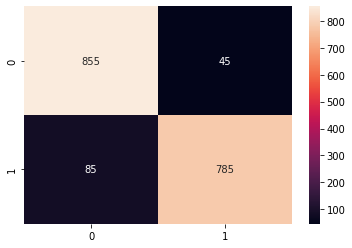

In [ ]:
import seaborn as sns
cf_matrix=sm.confusion_matrix(actual,p)
sns.heatmap(cf_matrix,annot=True,fmt='g')

In [ ]:
#Classification Report
from sklearn.metrics import classification_report
print(classification_report(actual,predicted))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       900
           1       0.95      0.90      0.92       870

    accuracy                           0.93      1770
   macro avg       0.93      0.93      0.93      1770
weighted avg       0.93      0.93      0.93      1770



b. SVM

In [ ]:
from sklearn.svm import SVC
svclassifier=SVC(kernel='rbf',C=10,gamma=1)
svclassifier.fit(train_review_tfidf,y_train)

SVC(C=10, gamma=1)

In [ ]:
nr=train_vectorizer.transform(X_test)
svclassifier.predict(nr)

array([0, 0, 1, ..., 1, 0, 1])

In [ ]:
predicted=svclassifier.predict(nr)
p=pd.DataFrame(predicted)
actual=y_test

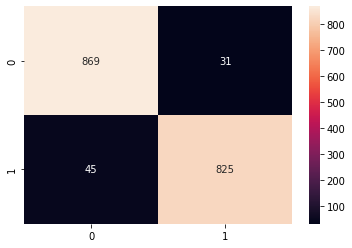

In [ ]:
cf_matrix=sm.confusion_matrix(actual,p)
sns.heatmap(cf_matrix,annot=True,fmt='g')

In [ ]:
#Classification Report
from sklearn.metrics import classification_report
print(classification_report(actual,predicted))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       900
           1       0.96      0.95      0.96       870

    accuracy                           0.96      1770
   macro avg       0.96      0.96      0.96      1770
weighted avg       0.96      0.96      0.96      1770



# WordCloud of negative reviews

In [ ]:
test_revs=pd.DataFrame(X_test)
test_revs=test_revs.reset_index()
print(test_revs.head())

   index  \
0   4420   
1   3712   
2   2895   
3   2742   
4   4335   

                                                                                                           NewReview  
0  maintain mcdonalds quality however due crowd multiplex get crowd time place not big enough large number customers  
1                                                                             mexican aloo tikki not full ingredient  
2                                                                                                        great place  
3                                                                         like place crowd good place food also good  
4                                                                                                              crowd  


In [ ]:
final_df=pd.DataFrame()
final_df['Predicted_Sentiment']=p[0]
final_df['Reviews']=test_revs['NewReview']
final_df

,Predicted_Sentiment,Reviews
0,0,maintain mcdonalds quality however due crowd multiplex get crowd time place not big enough large number customers
1,0,mexican aloo tikki not full ingredient
2,1,great place
3,1,like place crowd good place food also good
4,0,crowd
...,...,...
1765,0,poor food ambiance not good
1766,1,nice place hang friends
1767,1,variety food great adequate detail put individual food items serve always crowd mostly seat problem lot time prepare meals ready us plus high amount preservatives put food serve food taste pleasant comparatively cheap thus star
1768,0,find hair inside one mc veggie really surprise see


In [ ]:
from wordcloud import WordCloud
neg_words=[]
comment_words=' '
final_neg_df=final_df[final_df['Predicted_Sentiment']==0]
final_neg_df=final_neg_df.reset_index()
for i in range(len(final_neg_df)):
  tokens=final_neg_df['Reviews'][i].split()
  for token in tokens:
    neg_words.append(token)
  comment_words+=" ".join(tokens)+" "

print(comment_words)


#TODO : USE THIS LIST FOR WORDCLOUD! (REMOVE NOT)
cnt=Counter(neg_words)
cmmn=cnt.most_common(100)       
print(cmmn)

 maintain mcdonalds quality however due crowd multiplex get crowd time place not big enough large number customers mexican aloo tikki not full ingredient crowd sad environment substandard cooler drink depend fast service variety items lower price items contain less mayonnaise even make smaller size product bigger witness today start increase rat every item items price suggestion go burger king instead visit less options every month see new price regular customer seem burger king help save save mcd add leaf vegetable increase price rate rs talk mc café compete ccd starbucks not term good product term highest price product sell category really disappointment good thing mcd free wifi even start close branch delivery late quality bad not eatable also please check send overprice quality food no backup electricity power cut customers wait order unexpected poor service cheap food make theres personal profit brand name hope check review take corrective action order aloo tikki grill chicken bur

In [ ]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(comment_words)

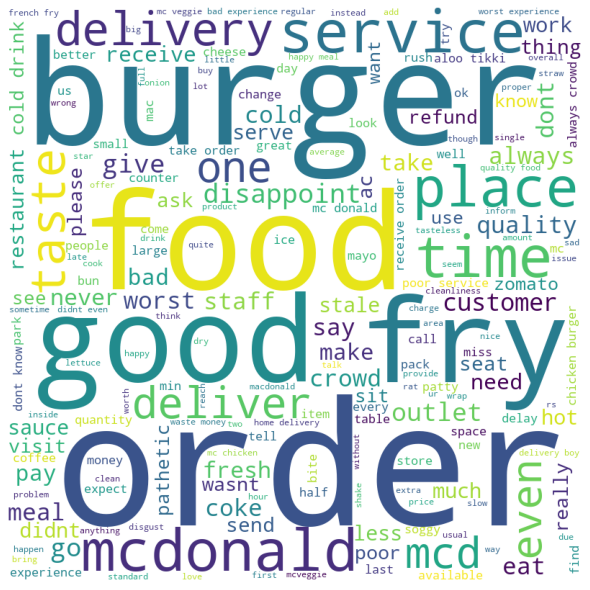

In [ ]:
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

Hyperparameter tuning the SVM!

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid={'C':[0.1,1,10,100],
            'gamma':[1,0.1,0.01,0.001,0.0001],
            'kernel':['rbf']}

grid=GridSearchCV(SVC(),param_grid,verbose=5)
grid.fit(train_review_tfidf,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.738 total time=   0.3s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.740 total time=   0.3s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.740 total time=   0.2s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.738 total time=   0.3s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.740 total time=   0.3s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.740 total time=   0.2s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.740 total time=   0.2s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.740 total time=   0.2s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.738 total time=   0.2s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.740 total time=   0.2s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.740 total time=   0.2s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=5)

In [ ]:
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}
0.9076827719196217
SVC(C=10, gamma=1)
